# Word Normalization

### José Pablo Kiesling Lange

In [1]:
import re
from collections import Counter
from itertools import combinations

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from tokenizers import Tokenizer, models, trainers, pre_tokenizers

from nltk.stem import SnowballStemmer

from Levenshtein import distance

In [2]:
corpus_path = "data/escher_comments.txt"

In [3]:
with open(corpus_path, "r", encoding="utf-8") as file:
    corpus = file.readlines()

In [4]:
corpus = [line.strip() for line in corpus if line.strip()]

## Estandarización

Para ver la efectivdad de la estandarización, se mostrará las 10 palabras más frecuentes del corpus antes y después de la estandarización. El objetivo es ver si hay modificación en la cantidad de dichas palabras o si una nueva palabra aparece con frecuencia.

In [5]:
def get_most_common_words(corpus, n=10):
    words = [word for line in corpus for word in line.split()]
    most_common = Counter(words).most_common(n)
    return most_common

In [6]:
most_common_words = get_most_common_words(corpus, n=10)
most_common_words

[('que', 45),
 ('de', 39),
 ('la', 32),
 ('un', 27),
 ('una', 26),
 ('el', 17),
 ('en', 16),
 ('esfera', 15),
 ('reflejo', 15),
 ('y', 14)]

#### Case Folding

Se hace una función que dado un corpus revisa si posee la misma palabra en mayúscula y minúscula.

In [7]:
def get_upper_lower_words(corpus):
    words = set(word for line in corpus for word in line.split())
    upper_lower_words = set()
    for word in words:
        if word.lower() in words and word.upper() in words:
            upper_lower_words.add(word)
    return upper_lower_words

In [8]:
upper_lower_words = get_upper_lower_words(corpus)
upper_lower_words

{'A', 'a'}

Dado que sí hay por lo menos una palabra que aparece en ambas formas, se procede a hacer un case folding (pasar todas las palabras a minúscula).

In [9]:
def case_folding(corpus):
    return [line.lower() for line in corpus]

#### Remove Punctuation

Dado que en las instrucciones para generar el corpus se pidió mínimo 2 oraciones, se asume que mínimo una de las oraciones tiene puntuación. Por lo tanto, se procede a eliminar la puntuación del corpus.

Esto se hace para evitar que palabras como `la,` o `la.` se cuenten como palabras diferentes a `la`.

In [10]:
def remove_punctuation(corpus):
    return [re.sub(r'[^\w\s]', '', line) for line in corpus]

In [11]:
def standarizate(corpus):
    corpus = case_folding(corpus)
    corpus = remove_punctuation(corpus)
    return corpus

In [12]:
corpus = standarizate(corpus)

### Corpus ya estandarizado

In [13]:
most_common_words = get_most_common_words(corpus, n=10)
most_common_words

[('que', 45),
 ('de', 39),
 ('la', 34),
 ('un', 30),
 ('una', 28),
 ('esfera', 18),
 ('en', 18),
 ('el', 17),
 ('reflejo', 16),
 ('se', 15)]

Como se puede apreciar:
- la palabra `la` se incrementó en `2`ocurrencias
- la palabra `un` se incrementó en `3` ocurrencias
- la palabra `una` se incrementó en `3`ocurrencias
- la palabra `esfera` se incrementó en `3` ocurrencias y subió al `6to` lugar
- la palabra `en` se incrementó en `2` ocurrencias y subió al `7mo` lugar
- la palabra `reflejo` se incrementó en `1` ocurrencia
- la palabra `se` **ingresó** al top 10

Por lo tanto, la estandarización ha tenido un efecto positivo en la, ya que ha incrementado la cantidad de ocurrencias de palabras comunes y ha eliminado las variaciones causadas por puntuación.

Algo a recalcar es la ausencia de la estandarización de palabras con o sin tilde. Esto es porque se entrenará el modelo `BPE` en español.

## BPE

La implementación se hará en base a la implementación de `LangformersBlog`

https://blog.langformers.com/bpe-tokenizer-explained/

En la instanciación del `BpeTrainer` se especifica el tamaño del vocabulario y los tokens especiales. Para definir el tamaño del vocabulario, se debe considerar el tamaño del corpus y la cantidad de palabras que se espera que aparezcan en el corpus. Por lo tanto, se hacen métodos para calcular el tamaño del vocabulario y la cantidad de palabras que se espera que aparezcan en el corpus.

In [14]:
def get_vocab_size(corpus):
    return len(set(word for line in corpus for word in line.split()))

In [15]:
vocab_size = get_vocab_size(corpus)
print(f"Vocabulario estimado por tokens únicos: {vocab_size}")

Vocabulario estimado por tokens únicos: 229


Dado que el corpus es pequeño, se define un tamaño de vocabulario de `300` y los tokens especiales son `[PAD]` y `[UNK]`.

In [16]:
tokenizer = Tokenizer(models.BPE())

In [17]:
trainer = trainers.BpeTrainer(
    vocab_size=300,
    special_tokens=["[PAD]", "[UNK]"]
)

El token `[PAD]` se utiliza para rellenar secuencias de longitud variable, mientras que el token `[UNK]` se utiliza para representar palabras desconocidas o fuera del vocabulario.

Ejemplo:
Si el corpus contiene las palabras `hola`, `mundo`, y `adiós`, el vocabulario podría ser:

```
{
    "[PAD]": 0,
    "[UNK]": 1,
    "hola": 2,
    "mundo": 3,
    "adiós": 4
}
```

Entonces si viniera el texto `hello mundo adiós` y otro texto `hola mundo`, el tokenizador lo convertiría a
1. [1, 3, 4] (donde `1` es el token `[UNK]` para `hello`)
2. [2, 3, 0] (donde `0` es el token `[PAD]` para la secuencia de longitud variable)

Es por ello que el uso de ambos tokens es importante para manejar secuencias de longitud variable y palabras desconocidas. En el caso de `PAD` es útil para rellenar secuencias más cortas, mientras que `UNK` es esencial para manejar palabras que no están en el vocabulario.

Sin embargo, en el caso de `PAD`, normalmente no aparece en el vocabulario final porque se añade a las secuencias al momento de batching no durante el entrenamiento del tokenizador.


In [18]:
tokenizer.train_from_iterator(corpus, trainer)

In [19]:
print("Vocabulary:", tokenizer.get_vocab())
tokenizer.save("tiny_tokenizer.json")

Vocabulary: {'se v': 110, 'el reflejo de ': 195, 'et': 177, 'parec': 186, 'v': 23, 'cen': 280, 'ta ': 142, 'ene ': 102, 'sí': 128, 'bi': 87, 'dis': 284, 'istal ': 250, 'mbi': 222, 'sí m': 151, 'veo a ': 257, 'su ': 93, 'lu': 156, ' m': 122, 'ilu': 288, 'sentimient': 260, 'or': 62, 'libros ': 206, 'perspec': 252, 'estra ': 266, 'la ': 47, 'ca ': 214, 'x': 24, 'em': 216, 'se ve ': 121, 'aliz': 249, 'va ': 96, 'en se ve ': 244, 'sosteniendo ': 172, 'un hombre ': 92, 'n': 15, 'que ': 42, 'e ': 33, 'el': 287, 'si': 85, 'os ': 66, 'como ': 170, 'bles ': 212, 'as': 274, 'alreded': 209, 'a ': 34, 'ma ': 182, 'is': 83, 'se': 228, 'a': 3, 'ant': 118, 'en la ': 163, 'una habitación ': 242, 'reflej': 56, 'ten': 115, 'xión ': 187, 'al ': 113, 'pue': 259, 'una ': 53, 'á ': 131, 'refleja ': 162, 'esfera ': 73, 's': 20, 'e': 7, 'reflect': 192, 'ser ': 253, 'reflejo ': 103, 'h': 10, 'pintur': 265, 'ación ': 137, 'de ': 43, 'ag': 153, 'su reflejo ': 200, 'r': 19, 'p': 17, 'oca ': 225, 'ver': 130, 'tur':

## Comparación con WordPiece y SentencePiece

### WordPiece

In [20]:
wordPiece_tokenizer = Tokenizer(models.WordPiece(unk_token="[UNK]"))
wordPiece_tokenizer.pre_tokenizer = pre_tokenizers.Whitespace()
wordPiece_trainer = trainers.WordPieceTrainer(vocab_size=300, special_tokens=["[PAD]", "[UNK]"])
wordPiece_tokenizer.train_from_iterator(corpus, wordPiece_trainer)

### SentencePiece

In [21]:
sentencePiece_tokenizer = Tokenizer(models.BPE())
sentencePiece_tokenizer.pre_tokenizer = pre_tokenizers.Whitespace()
sentencePiece_trainer = trainers.BpeTrainer(vocab_size=300, special_tokens=["[PAD]", "[UNK]"])
sentencePiece_tokenizer.train_from_iterator(corpus, sentencePiece_trainer)

In [22]:
sample = corpus[0][:60]

In [23]:
print("Sample text:", sample)
print("BPE Tokenization:", tokenizer.encode(sample).tokens)
print("WordPiece Tokenization:", wordPiece_tokenizer.encode(sample).tokens)
print("SentencePiece Tokenization:", sentencePiece_tokenizer.encode(sample).tokens)

Sample text: veo a un hombre explorando su propia percepción al sostener 
BPE Tokenization: ['veo a ', 'un hombre ', 'e', 'x', 'pl', 'or', 'ando ', 'su ', 'propi', 'a ', 'per', 'ce', 'pción ', 'al ', 'sosten', 'er', ' ']
WordPiece Tokenization: ['veo', 'a', 'un', 'hombre', 'e', '##x', '##p', '##lo', '##ra', '##n', '##do', 'su', 'propi', '##a', 'per', '##ce', '##pción', 'al', 'sosten', '##er']
SentencePiece Tokenization: ['veo', 'a', 'un', 'hombre', 'e', 'x', 'p', 'lo', 'r', 'ando', 'su', 'propia', 'percepción', 'al', 'sosten', 'er']


Como se puede apreciar, en `BPE` aprende tokens frecuentes como secuencias `('veo a ', 'un hombre ')`. A veces no separa en palabras individuales, sino en fragmentos largos o combinaciones si son frecuentes. Puede incluir espacios dentro de los tokens.

Por otro lado, `WordPiece` tiene una peculiaridad y es el uso de `##`para indicar que la subpalabra es parte de una palabra más larga. Además, fragmenta más las palabras conservando la semántica.

Finalmente, `SentencePiece` es similar a `BPE` (lo cual hace sentido ya que este modelo usa este algoritmo), pero no utiliza espacios como separadores. Tampoco usa `##`pero puede segmentar de forma más limpias las palabras, ya que no depende de espacios.

Por lo que en conclusión, `BPE` y `SentencePiece` son más flexibles en la segmentación de palabras, mientras que `WordPiece` es más estricto y conservador, lo que puede ser útil para modelos que requieren una segmentación más precisa de las palabras.


## Snowball Stemmer

In [24]:
stemmer = SnowballStemmer("spanish")

In [25]:
sample_stemmed = ""

In [26]:
words = sample.split()

In [27]:
for token in words:
    sample_stemmed += stemmer.stem(token) + " "
    print(f"Original: {token}, Stemmed: {stemmer.stem(token)}")
    
print("\nSample stemmed:", sample_stemmed.strip())

Original: veo, Stemmed: veo
Original: a, Stemmed: a
Original: un, Stemmed: un
Original: hombre, Stemmed: hombr
Original: explorando, Stemmed: explor
Original: su, Stemmed: su
Original: propia, Stemmed: propi
Original: percepción, Stemmed: percepcion
Original: al, Stemmed: al
Original: sostener, Stemmed: sosten

Sample stemmed: veo a un hombr explor su propi percepcion al sosten


Al hacer el stemming, se puede apreciar que verbos mantienen su raíz para que se pueda entender su lema. Por ejemplo, la subpalabra `explorando` se convierte en `explor`, la cual puede tener diferentes conjugaciones, y se sigue entendiendo como `explorar`.
Sin embargo, en el caso de sustantivos, se pierde la relación semántica original. Por ejemplo, la subpalabra `hombr` se puede entender como `hombre` u `hombro`. Esto se debe a que el algoritmo de stemming utilizado no tiene en cuenta el contexto de la palabra, por lo que puede generar raíces ambiguas.

Además, la subpalabra `percepción`se le remueve la tilde y se convierte en `percepcion`. Lo cual puede ser problemático, ya que en español la tilde es importante para la correcta pronunciación y significado de las palabras. Por lo tanto, al hacer el stemming, se pierde información importante sobre la palabra.

Por lo tanto, el stemming es útil para reducir las palabras a su raíz, pero puede generar raíces ambiguas y perder información importante sobre la palabra. En este caso, se recomienda utilizar lematización en lugar de stemming para preservar la relación semántica original de las palabras.

## Levenshtein

In [28]:
import pandas as pd
from sklearn.cluster import AgglomerativeClustering

In [29]:
n = len(corpus)
matriz = np.zeros((n, n))
for i in range(n):
    for j in range(n):
        if i != j:
            matriz[i][j] = distance(corpus[i], corpus[j])

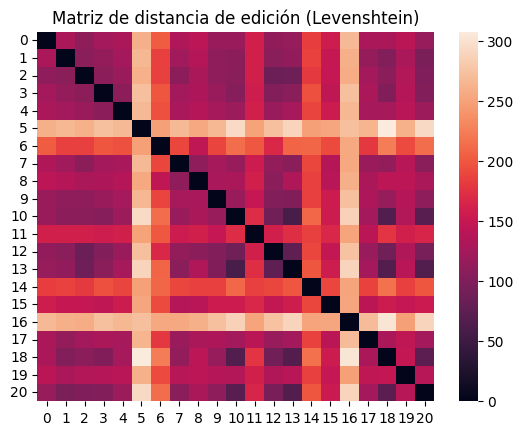

In [30]:
sns.heatmap(matriz)
plt.title("Matriz de distancia de edición (Levenshtein)")
plt.show()

Para determinar el número óptimo de clusters, se utiliza el método del codo. Este método consiste en calcular la suma de las distancias dentro de cada cluster para diferentes valores de `k` y graficar el resultado. El valor óptimo de `k` es aquel donde la disminución de la suma de distancias comienza a ser menos pronunciada.

In [31]:
def intra_cluster_sum(dist_matrix, labels):
    total = 0.0
    for c in np.unique(labels):
        idx = np.where(labels == c)[0]
        if len(idx) > 1:
            total += sum(dist_matrix[i, j] for i, j in combinations(idx, 2))
    return total

In [32]:
Ks = range(2, 21)
wcss = [] 

for k in Ks:
    model = AgglomerativeClustering(
        n_clusters=k,
        linkage="average"
    )
    labels = model.fit_predict(matriz)
    wcss.append(intra_cluster_sum(matriz, labels))

c:\Users\TheKi\OneDrive - UVG\Semestre X\Procesamiento de Lenguaje Natural\text-normalization\.venv\lib\site-packages\sklearn\cluster\_agglomerative.py:588: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  out = hierarchy.linkage(X, method=linkage, metric=affinity)
c:\Users\TheKi\OneDrive - UVG\Semestre X\Procesamiento de Lenguaje Natural\text-normalization\.venv\lib\site-packages\sklearn\cluster\_agglomerative.py:588: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  out = hierarchy.linkage(X, method=linkage, metric=affinity)
c:\Users\TheKi\OneDrive - UVG\Semestre X\Procesamiento de Lenguaje Natural\text-normalization\.venv\lib\site-packages\sklearn\cluster\_agglomerative.py:588: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  out = hierarchy.linkage(X, meth

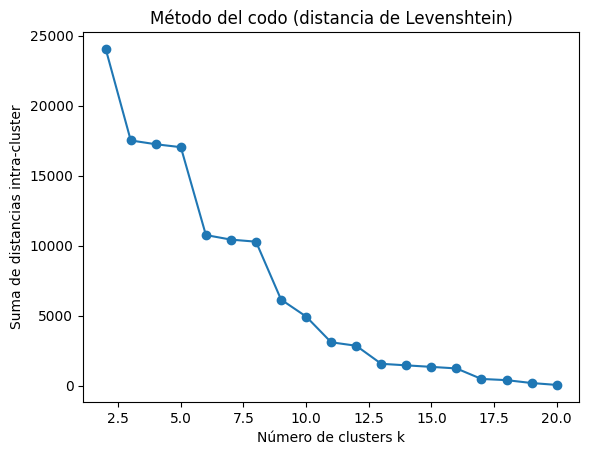

In [33]:
plt.plot(Ks, wcss, marker="o")
plt.title("Método del codo (distancia de Levenshtein)")
plt.xlabel("Número de clusters k")
plt.ylabel("Suma de distancias intra-cluster")
plt.show()


como se puede apreciar, el valor óptimo de `k` es `9`, ya que a partir de ese valor la disminución de la suma de distancias comienza a ser menos pronunciada. Por lo tanto, se puede concluir que el número óptimo de clusters es `9`.

In [34]:
k_opt = 9

In [35]:
model = AgglomerativeClustering(
    n_clusters=k_opt,
    linkage="average"
)
labels = model.fit_predict(matriz)

c:\Users\TheKi\OneDrive - UVG\Semestre X\Procesamiento de Lenguaje Natural\text-normalization\.venv\lib\site-packages\sklearn\cluster\_agglomerative.py:588: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  out = hierarchy.linkage(X, method=linkage, metric=affinity)


In [36]:
clusters = {c: [] for c in range(k_opt)}
for idx, label in enumerate(labels):
    clusters[label].append(corpus[idx])

In [37]:
for c, frases in clusters.items():
    print(f"\n🔸 Cluster {c}  (tamaño = {len(frases)})")
    for frase in frases:
        print("   •", frase)


🔸 Cluster 0  (tamaño = 11)
   • veo a un hombre explorando su propia percepción al sostener la esfera no solo contempla su reflejo sino que atrapa todo su entorno en un instante de autorreflexión y asombro
   • mediante una esfera se refleja la escena y a un hombre que se observa así mismo en el espejo con una sensación de reflexión sobre sí mismo y su alrededor
   • observo un nombre que sostiene una esfera en la que puede ver su reflejo y el del entorno me evoca un sentimiento de introspección y reflexión personal
   • me da la sensación de que es la representación del sentimiento de realization es el sentimiento que me provoca muchas veces el reflejo va más allá
   • veo un entendimiento de perspectiva reflejo y representación de la luz a nivel más analítico veo a un hombre observándose a sí mismo analizando el reflejo de su persona
   • un hombre sosteniendo una bola de cristal que lo refleja a él mismo en otro entorno actuando como un espejo o un túnel que muestra lo que él está 

Como se puede apreciar, el `Cluster 0` es el más grande (con `11` frases) y representa una visión común, literal y reflexiva de la pintura (`un hombre que sostiene una esfera reflectante donde se observa a sí mismo y su entorno`).

Por otro lado, el `Cluster 1`, con `3` frases, complementa esta visión al describir elementos más detallados del entorno físico (libros, muebles, ventana), y el efecto visual causado por la distorsión de la esfera.

Los demás `Clústeres (2 al 8)`, de solo una frase cada uno, representan explicaciones más subjetivas. Estos clústeres amplían el análisis al mostrar la varios enfoques dentro del corpus, diferenciándose del grupo central tanto por estilo como por contenido.